<a href="https://colab.research.google.com/github/geekzenpro/material-dashboard/blob/master/SPX500_ARIMAX_v1_2EM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install yfinance
!pip install pycaret
!pip install pandas_market_calendars

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.4/484.4 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.4/153.4 kB 18.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 70.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 77.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 77.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 69.2 MB/s eta 0:

In [15]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import time
import requests
import traceback
# Define the ticker symbols
# include real estate ticker
from pandas.tseries.offsets import BDay

API_KEY = 'JvOlZnErKIgvJ5yECAnUK6OFBoeKTioJ'

from datetime import datetime, timedelta

def calc_next_friday(d):
    d = datetime.strptime(d, '%Y-%m-%d')
    d += timedelta(7)
    while d.weekday() != 4:
        d += timedelta(1)
    return d

# Function to calculate the expected move using options data
def calculate_expected_move_from_polygonio(symbol, exp_date, close_price):

    api_key='JvOlZnErKIgvJ5yECAnUK6OFBoeKTioJ'

    last_friday_price = close_price


    last_friday = exp_date #datetime.strptime(exp_date, '%Y-%m-%d')

    contractExpirydate = datetime.strptime(last_friday, '%Y-%m-%d').strftime('%y%m%d')

    if last_friday_price < 100:
        polygonCallContractName = "O:"+symbol+contractExpirydate+"P"+ "000"+str(int(last_friday_price))+ "000"
    elif last_friday_price >= 1000 and last_friday_price < 10000:
        polygonCallContractName = "O:"+symbol+contractExpirydate+"P"+ "0"+str(int(last_friday_price))+ "000"
    else:
        polygonCallContractName = "O:"+symbol+contractExpirydate+"P"+ "00"+str(int(last_friday_price))+ "000"

    #frame polygon put contract name:
    if last_friday_price < 100:
        polygonPutContractName = "O:"+symbol+contractExpirydate+"C"+ "000"+str(int(last_friday_price))+ "000"
    elif last_friday_price >= 1000 and last_friday_price < 10000:
        polygonPutContractName = "O:"+symbol+contractExpirydate+"C"+ "0"+str(int(last_friday_price))+ "000"
    else:
        polygonPutContractName = "O:"+symbol+contractExpirydate+"C"+ "00"+str(int(last_friday_price))+ "000"

    #print(polygonCallContractName)
    #print(polygonPutContractName)
    try:
        #get the options call data from polygon.io
        url = f'https://api.polygon.io/v2/aggs/ticker/{polygonCallContractName}/range/1/day/{last_friday}/{last_friday}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}'
        print(url)
        options_data = requests.get(url).json()
        #print(options_data)
        atm_call_close_price = options_data['results'][0]['c']
        #print(polygonCallContractName, atm_call_close_price )
    except Exception as e:
        print(f"Failed to get options data for call: {e}")
        # print("Traceback: \n")
        # traceback.print_exc()  # This will print detailed traceback
        return None

    try:
        #get the options put data from polygon.io
        url = f'https://api.polygon.io/v2/aggs/ticker/{polygonPutContractName}/range/1/day/{last_friday}/{last_friday}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}'
        print(url)
        options_data = requests.get(url).json()
        #print(options_data)
        atm_put_close_price = options_data['results'][0]['c']
        #print(polygonPutContractName, atm_put_close_price)
    except Exception as e:
        print(f"Failed to get options data for put: {e}")
        # print("Traceback: \n")
        # traceback.print_exc()  # This will print detailed traceback
        return None


    try:

        #calculate the expected move
        #expected_move_friday = (atm_call_close_price + atm_put_close_price) * math.sqrt(7 / 365)  # 7 days to expiration
        expected_move_friday = (atm_call_close_price + atm_put_close_price)
        print(expected_move_friday)

        stock_price = last_friday_price

        expected_high_friday = stock_price + expected_move_friday
        expected_low_friday = stock_price - expected_move_friday

        #return polygonCallContractName, polygonPutContractName, round(expected_low_friday, 2), round(expected_high_friday, 2), round(last_friday_price, 2), round(expected_move_friday, 2)
        return round(expected_move_friday, 2)
    except Exception as e:
        print(f"Failed to calculate expected move: {e}")
        return None

tickers = ['XLK', 'XLF','XLI', 'XLE' ,'XLY','XLP','XLU','XLV','XLB', 'XLRE','XLC','SPY','QQQ','VXX', 'UVXY','^VIX', '^VIX9D', '^VIX3M']
#tickers = ['XLK', 'XLF', 'SPY','QQQ']
# # Define the start and end dates
# start_date = '2023-06-01'
# end_date = '2023-07-03'


#end date is the current date
today = datetime.today()+ timedelta(days=1)
end_date =today.strftime('%Y-%m-%d')
#start date is 180 trading days before the end date
start_date = datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days=290)
data = pd.DataFrame()
# Create an empty DataFrame for storing the returns
returns = pd.DataFrame()

# Download the historical data and calculate returns for each ticker
for ticker in tickers:


    data = yf.download(ticker, start=start_date, end=end_date)
  #   close = data['Adj Close']
  #   open = data['Open']
  #  #temp additions of open & close for comaprisions
  #   ret = open.rename(ticker + "_open")
  #   returns = pd.concat([returns, ret], axis=1)
  #   ret = close.rename(ticker + "_close")
  #   returns = pd.concat([returns, ret], axis=1)



    #Quant Returns
    close = data['Adj Close'].shift(-1)
    open = data['Open']
    ret = ((open - close) / close).fillna(0).rename(ticker +"_qreturns")
    #ret = close.pct_change().rename(ticker)
    # round of the returns to 4 decimal places
    ret = round(ret*100, 2)
    returns = pd.concat([returns, ret], axis=1)

    close = data['Adj Close']
    #open returns for the next day
    open = data['Open']

    ret = open.pct_change().shift(-1).rename(ticker +"_oreturns")
    #ret = close.pct_change().rename(ticker)
    # round of the returns to 4 decimal places
    ret = round(ret*100, 2)
    returns = pd.concat([returns, ret], axis=1)





    #close returns for the next day
    ret = close.pct_change().shift(-1).rename(ticker +"_creturns")
    #ret = close.pct_change().rename(ticker)
    # round of the returns to 4 decimal places
    ret = round(ret*100, 2)
    returns = pd.concat([returns, ret], axis=1)


    #high returns for the next day
    high = data['High']
    ret = ((close - high) / close).rename(ticker +"_hreturns")
    ret = round(ret*100, 2)
    returns = pd.concat([returns, ret], axis=1)


    #low returns for the next day
    low = data['Low']
    ret = ((close - low) / close).rename(ticker +"_lreturns")
    ret = round(ret*100, 2)
    returns = pd.concat([returns, ret], axis=1)

    #capture daily open to close returns
    ret = ((close - open) / open).rename(ticker + "_ocreturns")
    ret = round(ret*100, 2)
    returns = pd.concat([returns, ret], axis=1)

    data[ticker + '_close'] = round(data['Close'],2)
    returns = pd.concat([returns, data[ticker + '_close']], axis=1)

    #
    new_data = pd.DataFrame(index=returns.index)
    if ticker in ['SPY','QQQ']:
        # Start with an empty dictionary
        expected_moves = {}
        polygonCount=0
        EMCallDataIssue=False
        # Iterate through each date in the returns DataFrame

        for date in returns.index:
            # Calculate the last Friday's date for the current date
            last_friday = date - timedelta(days=(date.weekday() - 4) % 7)
            #print(date, last_friday)
            # Format the date as a string for the API call
            last_friday_str = last_friday.strftime('%Y-%m-%d')
            print(date, last_friday_str)
            # Check if the expected move for the last Friday already exists in the dictionary
            #print(returns)
            #print(returns.loc[date, ticker + '_close'])
            if last_friday_str not in expected_moves:
                EMCallDataIssue=False
                # If it doesn't exist, calculate the expected move and store it in the dictionary
                print("EM for this ", last_friday_str, " Not Available", ticker, returns.loc[date, ticker + '_close'])
                exected_move_as_of_friday = calculate_expected_move_from_polygonio(ticker, last_friday_str, returns.loc[date, ticker + '_close'])
                #time.sleep(31)
                polygonCount=polygonCount+1

                #print(polygonCount)
                if exected_move_as_of_friday is None:
                # Calculate the date of the previous Friday
                    prev_last_friday = date - timedelta(days=(date.weekday() - 4) % 7 + 7)
                    prev_last_friday_str = prev_last_friday.strftime('%Y-%m-%d')
                    # Get the expected move from the previous Friday from the dictionary
                    if prev_last_friday_str in expected_moves:
                        print("pulling data from previous last Friday, previous last Friday is ", prev_last_friday_str)
                        print(expected_moves)
                        expected_moves[last_friday_str] = expected_moves[prev_last_friday_str]
                        expected_move = expected_moves[prev_last_friday_str]
                        EMCallDataIssue=True
                    else:
                        print("Printing all Expected Moves calculated so far")
                        print(expected_moves)
                        print(f"No expected move available for date {prev_last_friday_str}")
                        #Assume a 2% expected move if no data is available previously as well
                        expected_moves[last_friday_str] = returns.loc[date, ticker + '_close'] * 0.02
                        expected_move = expected_moves[last_friday_str]
                        EMCallDataIssue=True
                else:
                    expected_moves[last_friday_str] = exected_move_as_of_friday
                    expected_move = exected_move_as_of_friday
                    EMCallDataIssue=False
                    print("No Calculation Issue for ", last_friday_str, " Expected Move is ", expected_move)

            # Retrieve the expected move for last Friday
            print("Expected Move", ticker, last_friday_str, expected_moves[last_friday_str])
            expected_move = expected_moves[last_friday_str]
            # Calculate expected_move_percent
            #expected_move_percent = expected_move / returns.loc[date, ticker + '_close']
            #check if returns.loc[last_friday, ticker + '_close']  exists or not


            if last_friday in returns.index:
                expected_move_percent =  (returns.loc[date, ticker + '_close'] - returns.loc[last_friday, ticker + '_close'] )/expected_move
                print ("Last Friday Close", returns.loc[last_friday, ticker + '_close'])
                print ("Today Close", returns.loc[date, ticker + '_close'])
                print ("Expected Move ", expected_move)
                print ("Expected Move Percent", expected_move_percent)
                lower_bound = returns.loc[last_friday, ticker + '_close'] - expected_move
                upper_bound = returns.loc[last_friday, ticker + '_close'] + expected_move
                if returns.loc[date, ticker + '_close'] < lower_bound:
                    expected_move_range = -1
                elif returns.loc[date, ticker + '_close'] > upper_bound:
                    expected_move_range = 1
                else:
                    expected_move_range = 0

            else:
                expected_move_percent =  0
                expected_move_range = 0
            # Calculate days_to_expire
            #days_to_expire = (last_friday + timedelta(days=8) - date).days  # expiry is the next Friday

            #days_to_expire = len(pd.date_range(start=date, end=last_friday + BDay(5), freq=BDay()))
            # Calculate days_to_expire
            # Calculate days_to_expire
            days_to_expire = len(pd.bdate_range(date, last_friday + pd.DateOffset(weeks=1))) - 1





            # if EMCallDataIssue is True:
            #      new_data.loc[date, ticker + '_EMCalcIssue'] = "True - PreviousWeekEMisUsed"
            # else:
            #      new_data.loc[date, ticker + '_EMCalcIssue'] = "False - No Issue"


            new_data.loc[date, ticker + '_EM'] = expected_move
            new_data.loc[date, ticker + '_Pct_of_EM'] = round(expected_move_percent,4)
            new_data.loc[date, ticker + '_EM_DTE'] = days_to_expire
            new_data.loc[date, ticker + '_EM_BR'] = expected_move_range

            # Concatenate the two DataFrames along axis=1
    returns = pd.concat([returns, new_data], axis=1)



# Ensure the index is a DatetimeIndex
returns.index = pd.to_datetime(returns.index)

# Create a mask for dates prior to today
mask = returns.index.date < datetime.today().date()

# Apply the mask to the DataFrame
returns = returns.loc[mask]

# Add a 'Date' column based on the index
returns['Date'] = returns.index.date

# Reset the index
returns.reset_index(drop=True, inplace=True)

returns["index"] = pd.to_datetime(returns["Date"])
returns.drop(columns=["Date"], inplace=True)
#returns.replace(-200, np.nan, inplace=True)
target = "SPY_returns"

#exclude = ['NMHC(GT)', 'AH']
#data.drop(columns=exclude, inplace=True)
returns.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
2022-09-26 00:00:00 2022-09-23
EM for this  2022-09-23  Not Available SPY 364.31
https://api.polygon.io/v2/aggs/ticker/O:SPY220923P00364000/range/1/day/2022-09-23/2022-09-2

,XLK_qreturns,XLK_oreturns,XLK_creturns,XLK_hreturns,XLK_lreturns,XLK_ocreturns,XLK_close,XLF_qreturns,XLF_oreturns,XLF_creturns,...,^VIX9D_ocreturns,^VIX9D_close,^VIX3M_qreturns,^VIX3M_oreturns,^VIX3M_creturns,^VIX3M_hreturns,^VIX3M_lreturns,^VIX3M_ocreturns,^VIX3M_close,index
0,0.98,0.93,0.13,-2.81,-0.43,-1.10,122.88,2.88,-0.06,-0.43,...,-1.16,34.14,-3.21,-0.77,1.10,-0.41,5.76,2.19,31.77,2022-09-26
1,0.86,-1.84,1.06,-2.88,0.21,-1.89,123.04,0.83,-0.91,1.97,...,1.24,33.49,0.88,4.73,-4.79,-3.05,5.29,4.12,32.12,2022-09-27
2,1.65,0.28,-2.61,-1.21,1.76,1.01,124.34,1.18,0.59,-1.26,...,-10.23,31.16,1.80,-2.26,3.79,-6.90,0.56,-5.35,30.58,2022-09-28
3,3.92,-1.59,-1.92,-2.17,0.47,-1.90,121.10,2.72,-0.13,-0.91,...,-1.30,32.67,-0.88,0.47,0.38,-4.06,0.54,0.51,31.74,2022-09-29
4,-0.80,-0.74,3.10,-3.79,-0.53,-2.22,118.78,-0.11,0.00,2.70,...,-3.73,31.19,3.39,-1.42,-3.67,-1.98,4.36,0.41,31.86,2022-09-30


In [16]:
returns.head()

,XLK_qreturns,XLK_oreturns,XLK_creturns,XLK_hreturns,XLK_lreturns,XLK_ocreturns,XLK_close,XLF_qreturns,XLF_oreturns,XLF_creturns,...,^VIX9D_ocreturns,^VIX9D_close,^VIX3M_qreturns,^VIX3M_oreturns,^VIX3M_creturns,^VIX3M_hreturns,^VIX3M_lreturns,^VIX3M_ocreturns,^VIX3M_close,index
0,0.98,0.93,0.13,-2.81,-0.43,-1.10,122.88,2.88,-0.06,-0.43,...,-1.16,34.14,-3.21,-0.77,1.10,-0.41,5.76,2.19,31.77,2022-09-26
1,0.86,-1.84,1.06,-2.88,0.21,-1.89,123.04,0.83,-0.91,1.97,...,1.24,33.49,0.88,4.73,-4.79,-3.05,5.29,4.12,32.12,2022-09-27
2,1.65,0.28,-2.61,-1.21,1.76,1.01,124.34,1.18,0.59,-1.26,...,-10.23,31.16,1.80,-2.26,3.79,-6.90,0.56,-5.35,30.58,2022-09-28
3,3.92,-1.59,-1.92,-2.17,0.47,-1.90,121.10,2.72,-0.13,-0.91,...,-1.30,32.67,-0.88,0.47,0.38,-4.06,0.54,0.51,31.74,2022-09-29
4,-0.80,-0.74,3.10,-3.79,-0.53,-2.22,118.78,-0.11,0.00,2.70,...,-3.73,31.19,3.39,-1.42,-3.67,-1.98,4.36,0.41,31.86,2022-09-30


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Now you can read a csv file from your Drive as follows:
import pandas as pd
df = pd.read_csv('/content/EXO_ARIMAX_Dataset_EM2.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
returns =df

In [17]:
import numpy as np
import pandas as pd
from pycaret.datasets import get_data
from pycaret.time_series import TSForecastingExperiment
#returns.drop(columns=["Date"], inplace=True)
from datetime import datetime, timedelta
returns["index"] = pd.to_datetime(returns["index"] )
# returns.drop(columns=["Date"], inplace=True)
returns.replace(-200, np.nan, inplace=True)
target = "SPY_qreturns"

#exclude = ['NMHC(GT)', 'AH']
#data.drop(columns=exclude, inplace=True)
returns.head()

,XLK_qreturns,XLK_oreturns,XLK_creturns,XLK_hreturns,XLK_lreturns,XLK_ocreturns,XLK_close,XLF_qreturns,XLF_oreturns,XLF_creturns,...,^VIX9D_ocreturns,^VIX9D_close,^VIX3M_qreturns,^VIX3M_oreturns,^VIX3M_creturns,^VIX3M_hreturns,^VIX3M_lreturns,^VIX3M_ocreturns,^VIX3M_close,index
0,0.98,0.93,0.13,-2.81,-0.43,-1.10,122.88,2.88,-0.06,-0.43,...,-1.16,34.14,-3.21,-0.77,1.10,-0.41,5.76,2.19,31.77,2022-09-26
1,0.86,-1.84,1.06,-2.88,0.21,-1.89,123.04,0.83,-0.91,1.97,...,1.24,33.49,0.88,4.73,-4.79,-3.05,5.29,4.12,32.12,2022-09-27
2,1.65,0.28,-2.61,-1.21,1.76,1.01,124.34,1.18,0.59,-1.26,...,-10.23,31.16,1.80,-2.26,3.79,-6.90,0.56,-5.35,30.58,2022-09-28
3,3.92,-1.59,-1.92,-2.17,0.47,-1.90,121.10,2.72,-0.13,-0.91,...,-1.30,32.67,-0.88,0.47,0.38,-4.06,0.54,0.51,31.74,2022-09-29
4,-0.80,-0.74,3.10,-3.79,-0.53,-2.22,118.78,-0.11,0.00,2.70,...,-3.73,31.19,3.39,-1.42,-3.67,-1.98,4.36,0.41,31.86,2022-09-30


In [18]:
global_fig_settings = {
    # "renderer": "notebook",
    "renderer": "png",
    "width": 1000,
    "height": 600,
}

In [ ]:
# from datetime import datetime, timedelta
# #end date is the current date
# today = datetime.today()+ timedelta(days=1)
# end_date =today.strftime('%Y-%m-%d')
# #start date is 180 trading days before the end date
# start_date = datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days=60)

# target = "SPY_returns"

In [ ]:


# from pandas._libs import index
# import pandas_market_calendars as mcal

# nyse = mcal.get_calendar('NYSE')

# schedule = nyse.schedule(start_date, end_date)

# data_uni = returns.copy()
# data_uni.set_index("index", inplace=True)
# data_uni.reindex(schedule.index)
# data_uni = data_uni[target]
# data_uni = data_uni.asfreq('B')
# # returns = returns.reindex(schedule.index)
# # returns = returns.fillna(method='ffill')
# data_uni.head()
# exp_uni = TSForecastingExperiment()
# exp_uni.setup(
#     data=data_uni, fh=3,
#     numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
#     fig_kwargs=global_fig_settings, session_id=42
# )
# model = exp_uni.create_model("auto_arima")

,Description,Value
0,session_id,42
1,Target,SPY_returns
2,Approach,Univariate
3,Exogenous Variables,Not Present
4,Original data shape,"(41, 1)"
5,Transformed data shape,"(41, 1)"
6,Transformed train set shape,"(38, 1)"
7,Transformed test set shape,"(3, 1)"
8,Rows with missing values,7.3%
9,Fold Generator,ExpandingWindowSplitter


,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,R2
0,2023-06-22,0.2750,0.3162,0.2500,0.3619,1.0000,2.0000,-0.2558
1,2023-06-27,0.7109,0.6970,0.6033,0.7632,1.0000,2.0000,-1.6665
2,2023-06-30,0.6603,0.5381,0.5571,0.5785,1.7587,2.0000,-12.8268
Mean,NaT,0.5487,0.5171,0.4702,0.5678,1.2529,2.0000,-4.9164
SD,NaT,0.1946,0.1562,0.1568,0.1640,0.3576,0.0000,5.6231


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [19]:

from pandas._libs import index
import pandas_market_calendars as mcal

nyse = mcal.get_calendar('NYSE')

schedule = nyse.schedule(start_date, end_date)
# Specify the date to exclude
#date_to_exclude = '2023-07-11'

# Exclude the row with the specified date
# returns = returns[returns['index'] != date_to_exclude]
exclude = ['XLK_close', 'XLF_close','XLI_close', 'XLE_close' ,'XLY_close','XLP_close','XLU_close','XLV_close','XLB_close', 'XLRE_close','XLC_close','SPY_close','QQQ_close','VXX_close', 'UVXY_close','^VIX_close', '^VIX9D_close', '^VIX3M_close']

data_exo = returns.copy()
data_exo.drop(columns=exclude, inplace=True)
data_exo.set_index("index", inplace=True)
#data_exo.reindex(schedule.index)
data_exo = data_exo.asfreq('B')
# returns = returns.reindex(schedule.index)
# returns = returns.fillna(method='ffill')
data_exo.head()



,XLK_qreturns,XLK_oreturns,XLK_creturns,XLK_hreturns,XLK_lreturns,XLK_ocreturns,XLF_qreturns,XLF_oreturns,XLF_creturns,XLF_hreturns,...,^VIX9D_creturns,^VIX9D_hreturns,^VIX9D_lreturns,^VIX9D_ocreturns,^VIX3M_qreturns,^VIX3M_oreturns,^VIX3M_creturns,^VIX3M_hreturns,^VIX3M_lreturns,^VIX3M_ocreturns
index,,,,,,,,,,,,,,,,,,,,,
2022-09-26,0.98,0.93,0.13,-2.81,-0.43,-1.10,2.88,-0.06,-0.43,-3.41,...,-1.90,-2.90,6.85,-1.16,-3.21,-0.77,1.10,-0.41,5.76,2.19
2022-09-27,0.86,-1.84,1.06,-2.88,0.21,-1.89,0.83,-0.91,1.97,-3.35,...,-6.96,-8.93,4.87,1.24,0.88,4.73,-4.79,-3.05,5.29,4.12
2022-09-28,1.65,0.28,-2.61,-1.21,1.76,1.01,1.18,0.59,-1.26,-2.17,...,4.85,-15.02,0.51,-10.23,1.80,-2.26,3.79,-6.90,0.56,-5.35
2022-09-29,3.92,-1.59,-1.92,-2.17,0.47,-1.90,2.72,-0.13,-0.91,-2.18,...,-4.53,-8.02,0.77,-1.30,-0.88,0.47,0.38,-4.06,0.54,0.51
2022-09-30,-0.80,-0.74,3.10,-3.79,-0.53,-2.22,-0.11,0.00,2.70,-3.86,...,-1.73,-5.84,7.31,-3.73,3.39,-1.42,-3.67,-1.98,4.36,0.41


In [20]:
from sktime.datatypes import check_raise

check_raise(data_exo, mtype='pd.DataFrame')

True

In [ ]:
object_cols = data_exo.select_dtypes(include='object').columns
print(object_cols)

Index(['index'], dtype='object')


In [21]:
print(data_exo.dtypes)


XLK_qreturns        float64
XLK_oreturns        float64
XLK_creturns        float64
XLK_hreturns        float64
XLK_lreturns        float64
                     ...   
^VIX3M_oreturns     float64
^VIX3M_creturns     float64
^VIX3M_hreturns     float64
^VIX3M_lreturns     float64
^VIX3M_ocreturns    float64
Length: 116, dtype: object


In [46]:
exp_exo = TSForecastingExperiment()
exp_exo.setup(
    data=data_exo, target=target, fh=1,
    numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
    fig_kwargs=global_fig_settings, session_id=18
)

,Description,Value
0,session_id,18
1,Target,SPY_qreturns
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(207, 116)"
5,Transformed data shape,"(207, 116)"
6,Transformed train set shape,"(206, 116)"
7,Transformed test set shape,"(1, 116)"
8,Rows with missing values,4.3%
9,Fold Generator,ExpandingWindowSplitter


In [47]:
model_exo = exp_exo.create_model("auto_arima")

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2023-07-05,0.0100,0.0076,0.0131,0.0131,0.0654,0.0676
1,2023-07-06,0.0026,0.0020,0.0034,0.0034,0.0148,0.0149
2,2023-07-07,0.0006,0.0004,0.0007,0.0007,0.0007,0.0007
Mean,NaT,0.0044,0.0033,0.0057,0.0057,0.0270,0.0277
SD,NaT,0.0041,0.0031,0.0053,0.0053,0.0278,0.0288


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

<Axes: xlabel='index'>

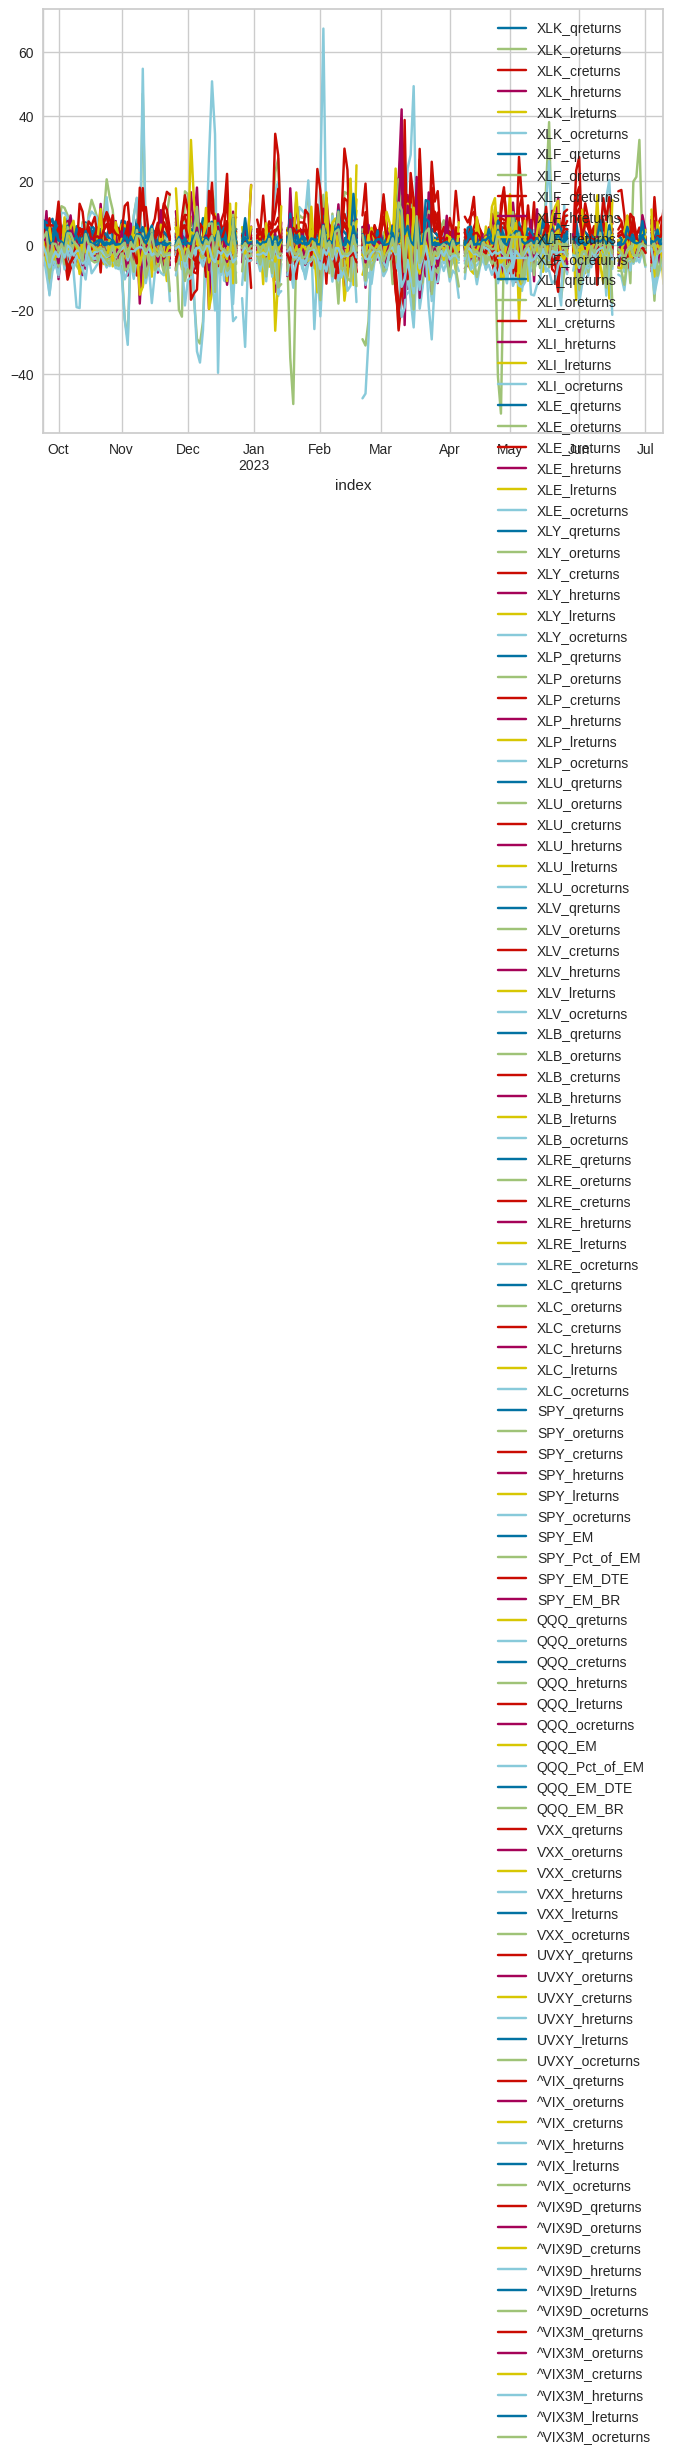

In [24]:
data_exo.plot()

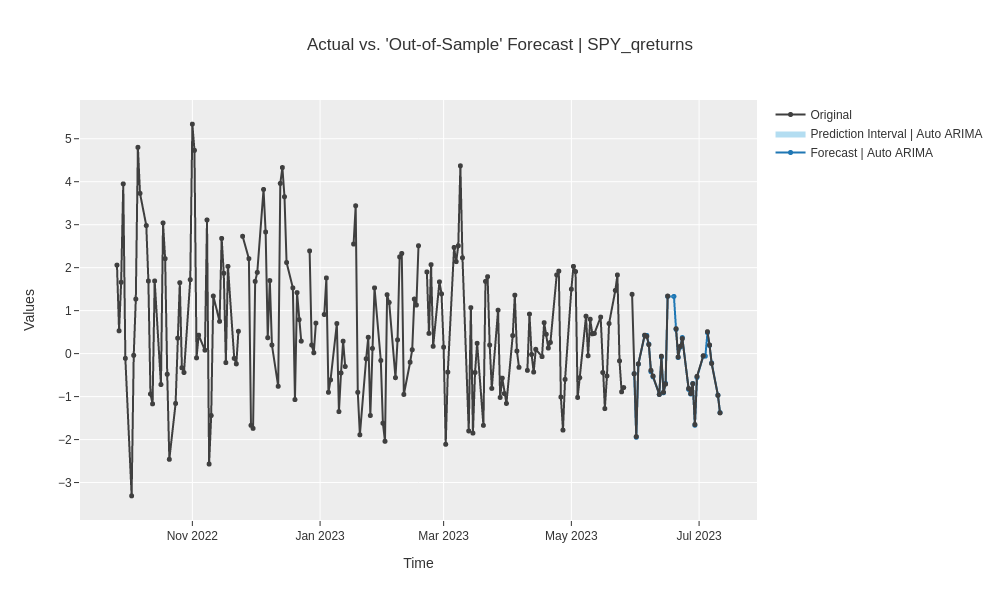

In [33]:
exp_exo.plot_model(model_exo)

In [51]:
import pandas as pd

# Assuming `model_exo` is your fitted model
summary = model_exo.summary()

# Convert the summary table to a DataFrame
summary_df = pd.DataFrame(summary.tables[1].data[1:], columns=summary.tables[1].data[0])

# Convert the 'coef' column to floats so they can be sorted
summary_df['coef'] = summary_df['coef'].astype(float)

# Sort the DataFrame by the 'coef' column in descending order
sorted_summary_df = summary_df.sort_values('coef', ascending=False)
pd.set_option('display.max_rows', None)
print(sorted_summary_df)
#print(sorted_summary_df['std err'] > 0.0015)


                           coef    std err          z   P>|z|     [0.025  \
48      XLV_ocreturns  0.179500      0.098      1.839   0.066     -0.012   
45       XLV_creturns  0.176100      0.095      1.848   0.065     -0.011   
43       XLV_qreturns  0.175800      0.094      1.867   0.062     -0.009   
81      QQQ_ocreturns  0.138100      0.124      1.117   0.264     -0.104   
1        XLK_qreturns  0.136000      0.074      1.826   0.068     -0.010   
3        XLK_creturns  0.132000      0.077      1.711   0.087     -0.019   
6       XLK_ocreturns  0.130800      0.077      1.695   0.090     -0.020   
12      XLF_ocreturns  0.123000      0.066      1.868   0.062     -0.006   
76       QQQ_qreturns  0.122600      0.122      1.005   0.315     -0.116   
78       QQQ_creturns  0.121800      0.126      0.967   0.334     -0.125   
9        XLF_creturns  0.120400      0.064      1.871   0.061     -0.006   
7        XLF_qreturns  0.118300      0.063      1.876   0.061     -0.005   
31       XLP

# New Section

# New Section

In [ ]:
sorted_summary = summary_df.sort_values(by='coef', ascending=False)


AttributeError: ignored

In [ ]:
exp_slim = TSForecastingExperiment()
keep = [target, "index", 'NOx(GT)', "PT08.S3(NOx)", "RH"]
data_slim = data[keep]
exp_slim.setup(
    data=data_slim, target=target, index="index", fh=48,
    numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
    fig_kwargs=global_fig_settings, session_id=42
)

In [35]:
exp = TSForecastingExperiment()

In [48]:
exp.setup(data=data_exo, target=target, fh=1,
    numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
    fig_kwargs=global_fig_settings, session_id=18)

,Description,Value
0,session_id,18
1,Target,SPY_qreturns
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(207, 116)"
5,Transformed data shape,"(207, 116)"
6,Transformed train set shape,"(206, 116)"
7,Transformed test set shape,"(1, 116)"
8,Rows with missing values,4.3%
9,Fold Generator,ExpandingWindowSplitter


In [49]:
exp.compare_models()

,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,TT (Sec)
arima,ARIMA,0.0041,0.0032,0.0054,0.0054,0.0253,0.0259,13.7800
auto_arima,Auto ARIMA,0.0044,0.0033,0.0057,0.0057,0.0270,0.0277,74.3800
lr_cds_dt,Linear w/ Cond. Deseasonalize & Detrending,0.0692,0.0526,0.0901,0.0901,0.2887,0.2435,0.7333
lightgbm_cds_dt,Light Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.1133,0.0862,0.1479,0.1479,0.6717,0.7199,0.8600
et_cds_dt,Extra Trees w/ Cond. Deseasonalize & Detrending,0.1403,0.1067,0.1832,0.1832,0.8140,0.8182,1.0667
br_cds_dt,Bayesian Ridge w/ Cond. Deseasonalize & Detrending,0.1561,0.1186,0.2030,0.2030,0.5997,0.3675,0.5533
ridge_cds_dt,Ridge w/ Cond. Deseasonalize & Detrending,0.1573,0.1195,0.2047,0.2047,0.6523,0.3940,1.1333
huber_cds_dt,Huber w/ Cond. Deseasonalize & Detrending,0.1665,0.1265,0.2165,0.2165,0.5910,0.3768,0.5967
gbr_cds_dt,Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.1969,0.1497,0.2566,0.2566,0.9572,0.9323,2.2167
xgboost_cds_dt,Extreme Gradient Boosting w/ Cond. Deseasonalize & Detrending,0.1998,0.1520,0.2607,0.2607,1.1834,0.9705,1.0633


Processing:   0%|          | 0/93 [00:00<?, ?it/s]

ARIMA()

In [60]:
tuned_model_exo = exp.tune_model(model_exo)

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2023-07-05,0.0100,0.0076,0.0131,0.0131,0.0654,0.0676
1,2023-07-06,0.0026,0.0020,0.0034,0.0034,0.0148,0.0149
2,2023-07-07,0.0006,0.0004,0.0007,0.0007,0.0007,0.0007
Mean,NaT,0.0044,0.0033,0.0057,0.0057,0.0270,0.0277
SD,NaT,0.0041,0.0031,0.0053,0.0053,0.0278,0.0288


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  3.7min finished


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


In [62]:
import pandas as pd

# Assuming `model_exo` is your fitted model
summary = tuned_model_exo.summary()

# Convert the summary table to a DataFrame
summary_df = pd.DataFrame(summary.tables[1].data[1:], columns=summary.tables[1].data[0])

# Convert the 'coef' column to floats so they can be sorted
summary_df['coef'] = summary_df['coef'].astype(float)

# Sort the DataFrame by the 'coef' column in descending order
sorted_summary_df = summary_df.sort_values('z', ascending=False)
pd.set_option('display.max_rows', None)
print(sorted_summary_df)
#print(sorted_summary_df['std err'] > 0.0015)

                           coef    std err          z   P>|z|     [0.025  \
71      SPY_ocreturns -1.018300      0.024    -41.906   0.000     -1.066   
68       SPY_creturns -0.991200      0.024    -41.795   0.000     -1.038   
94      UVXY_creturns -0.041100      0.021     -2.003   0.045     -0.081   
97     UVXY_ocreturns -0.040100      0.021     -1.913   0.056     -0.081   
92      UVXY_qreturns -0.037600      0.020     -1.884   0.060     -0.077   
69       SPY_hreturns -0.013700      0.009     -1.456   0.145     -0.032   
77       QQQ_oreturns -0.012700      0.010     -1.323   0.186     -0.031   
41       XLU_lreturns -0.004300      0.004     -1.239   0.215     -0.011   
73      SPY_Pct_of_EM -0.000200      0.000     -0.981   0.327     -0.000   
114   ^VIX3M_lreturns -0.002900      0.003     -0.972   0.331     -0.009   
40       XLU_hreturns -0.002800      0.004     -0.751   0.453     -0.010   
53       XLB_lreturns -0.003800      0.005     -0.718   0.473     -0.014   
59      XLRE

In [45]:
final_exo_model = exp_exo.finalize_model(model_exo)

KeyboardInterrupt: ignored

In [128]:
exp_slim = TSForecastingExperiment()
keep = [target, 'SPY_ocreturns', 'SPY_creturns', 'UVXY_creturns',
       'UVXY_ocreturns', 'UVXY_qreturns', 'XLF_qreturns', 'XLF_creturns',
       'XLF_ocreturns', 'XLV_qreturns', 'XLV_creturns', 'index']

data_c = returns.copy()
data_slim = data_c[keep]
data_slim.set_index("index", inplace=True)
#data_exo.reindex(schedule.index)
data_slim = data_slim.asfreq('B')
# returns = returns.reindex(schedule.index)
# returns = returns.fillna(method='ffill')
data_slim.head()




,SPY_qreturns,SPY_ocreturns,SPY_creturns,UVXY_creturns,UVXY_ocreturns,UVXY_qreturns,XLF_qreturns,XLF_creturns,XLF_ocreturns,XLV_qreturns,XLV_creturns
index,,,,,,,,,,,
2022-09-26,2.06,-1.77,-0.26,2.00,1.96,-3.85,2.88,-0.43,-2.39,1.90,-0.30
2022-09-27,0.53,-2.45,1.97,-6.13,6.08,0.42,0.83,1.97,-2.74,0.05,2.19
2022-09-28,1.66,0.46,-2.09,4.52,-5.16,0.88,1.18,-1.26,0.09,1.29,-0.84
2022-09-29,3.95,-2.29,-1.55,2.88,0.48,-3.27,2.72,-0.91,-1.75,3.19,-1.38
2022-09-30,-0.11,-2.46,2.64,-6.61,1.98,5.00,-0.11,2.70,-2.52,0.57,2.06


In [130]:
exp_slim.setup(
    data=data_slim, target=target, fh=1,
    numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
    fig_kwargs=global_fig_settings, session_id=42
)


,Description,Value
0,session_id,42
1,Target,SPY_qreturns
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(207, 11)"
5,Transformed data shape,"(207, 11)"
6,Transformed train set shape,"(206, 11)"
7,Transformed test set shape,"(1, 11)"
8,Rows with missing values,4.3%
9,Fold Generator,ExpandingWindowSplitter


In [131]:
model_slim = exp_slim.create_model("auto_arima")

,cutoff,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE
0,2023-07-05,0.0088,0.0067,0.0115,0.0115,0.0577,0.0561
1,2023-07-06,0.0092,0.0070,0.0120,0.0120,0.0522,0.0536
2,2023-07-07,0.0067,0.0050,0.0086,0.0086,0.0089,0.0089
Mean,NaT,0.0082,0.0063,0.0107,0.0107,0.0396,0.0396
SD,NaT,0.0011,0.0009,0.0015,0.0015,0.0218,0.0217


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

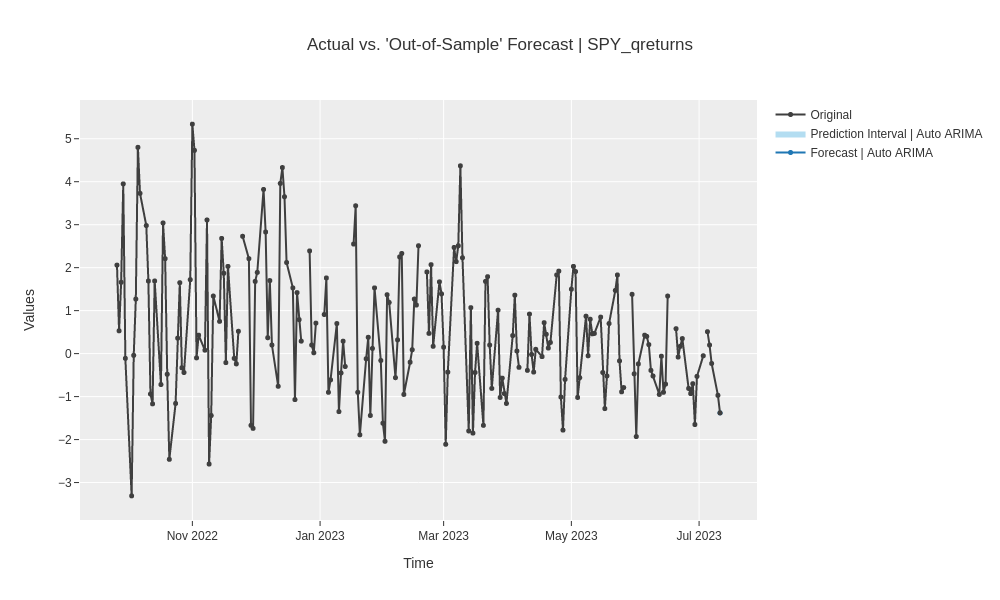

In [133]:
exp_slim.plot_model(model_slim)

In [134]:
final_slim_model = exp_slim.finalize_model(model_slim)

In [135]:
_ = exp_slim.save_model(final_slim_model, "final_slim_model")

Transformation Pipeline and Model Successfully Saved


In [136]:
def safe_predict(exp, model):
    """Prediction wrapper for demo purposes."""
    try:
        exp.predict_model(model, fh =3)
    except ValueError as exception:
        print(exception)
        exo_vars = exp.exogenous_variables
        print(f"{len(exo_vars)} exogenous variables (X) needed in order to make future predictions:\n{exo_vars}")



In [137]:
safe_predict(exp_slim, final_slim_model)

Model was trained with exogenous variables but you have not passed any for predictions. Please pass exogenous variables to make predictions.
10 exogenous variables (X) needed in order to make future predictions:
['SPY_ocreturns', 'SPY_creturns', 'UVXY_creturns', 'UVXY_ocreturns', 'UVXY_qreturns', 'XLF_qreturns', 'XLF_creturns', 'XLF_ocreturns', 'XLV_qreturns', 'XLV_creturns']


In [153]:
exog_vars = ['index','SPY_ocreturns', 'SPY_creturns', 'UVXY_creturns',
       'UVXY_ocreturns', 'UVXY_qreturns', 'XLF_qreturns', 'XLF_creturns',
       'XLF_ocreturns', 'XLV_qreturns', 'XLV_creturns', ]
data_sim_c = returns.copy()
data_sim_exo = data_sim_c[exog_vars]
data_sim_exo["index"] = pd.to_datetime(data_sim_exo["index"] )
data_sim_exo.set_index("index", inplace=True)
#data_exo.reindex(schedule.index)
data_sim_exo = data_slim.asfreq('B')
data_sim_exo.head()

,SPY_qreturns,SPY_ocreturns,SPY_creturns,UVXY_creturns,UVXY_ocreturns,UVXY_qreturns,XLF_qreturns,XLF_creturns,XLF_ocreturns,XLV_qreturns,XLV_creturns
index,,,,,,,,,,,
2022-09-26,2.06,-1.77,-0.26,2.00,1.96,-3.85,2.88,-0.43,-2.39,1.90,-0.30
2022-09-27,0.53,-2.45,1.97,-6.13,6.08,0.42,0.83,1.97,-2.74,0.05,2.19
2022-09-28,1.66,0.46,-2.09,4.52,-5.16,0.88,1.18,-1.26,0.09,1.29,-0.84
2022-09-29,3.95,-2.29,-1.55,2.88,0.48,-3.27,2.72,-0.91,-1.75,3.19,-1.38
2022-09-30,-0.11,-2.46,2.64,-6.61,1.98,5.00,-0.11,2.70,-2.52,0.57,2.06


In [156]:
exog_exps = []
exog_models = []
exog_vars =  ['SPY_ocreturns', 'SPY_creturns', 'UVXY_creturns',
       'UVXY_ocreturns', 'UVXY_qreturns', 'XLF_qreturns', 'XLF_creturns',
       'XLF_ocreturns', 'XLV_qreturns', 'XLV_creturns', ]
for exog_var in exog_vars:
    exog_exp = TSForecastingExperiment()
    exog_exp.setup(
        data=data_sim_exo, target=exog_var, fh=1,
        numeric_imputation_target="ffill", numeric_imputation_exogenous="ffill",
        fig_kwargs=global_fig_settings, session_id=43
    )


    # Users can customize how to model future exogenous variables i.e. add
    # more steps and models to potentially get better models at the expense
    # of higher modeling time.
    best = exog_exp.compare_models(
        sort="mase", include=["auto_arima"]
    )
    final_exog_model = "exog_exp.finalize_model(best)"
    exog_exps.append(exog_exp)
    exog_models.append(final_exog_model)

# Step 2: Get future predictions for exog variables ----
future_exog = [
    exog_exp.predict_model(exog_model)
    for exog_exp, exog_model in zip(exog_exps, exog_models)
]
future_exog = pd.concat(future_exog, axis=1)
future_exog.columns = exog_vars

,Description,Value
0,session_id,43
1,Target,SPY_ocreturns
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(207, 11)"
5,Transformed data shape,"(207, 11)"
6,Transformed train set shape,"(206, 11)"
7,Transformed test set shape,"(1, 11)"
8,Rows with missing values,4.3%
9,Fold Generator,ExpandingWindowSplitter


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,TT (Sec)
auto_arima,Auto ARIMA,0.0107,0.0078,0.0109,0.0109,0.2891,0.3783,22.7633


Processing:   0%|          | 0/9 [00:00<?, ?it/s]

,Description,Value
0,session_id,43
1,Target,SPY_creturns
2,Approach,Univariate
3,Exogenous Variables,Present
4,Original data shape,"(207, 11)"
5,Transformed data shape,"(207, 11)"
6,Transformed train set shape,"(206, 11)"
7,Transformed test set shape,"(1, 11)"
8,Rows with missing values,4.3%
9,Fold Generator,ExpandingWindowSplitter


,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,22:57:27
Status,. . . . . . . . . . . . . . . . . .,Fitting 3 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Auto ARIMA


,Model,MASE,RMSSE,MAE,RMSE,MAPE,SMAPE,TT (Sec)


Processing:   0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
future_exog

In [126]:
summary_df = pd.DataFrame(summary.tables[1].data[1:], columns=summary.tables[1].data[0])
summary_df.set_index(summary_df.columns[0], inplace = True)
summary_df.index.name = 'features'
summary_df['abs_z'] = summary_df['z'].astype(float).abs()

#print(summary_df)
top_features = summary_df.nlargest(11,'abs_z')
print(top_features.index)


Index(['SPY_ocreturns', 'SPY_creturns', 'sigma2', 'UVXY_creturns',
       'UVXY_ocreturns', 'UVXY_qreturns', 'XLF_qreturns', 'XLF_creturns',
       'XLF_ocreturns', 'XLV_qreturns', 'XLV_creturns'],
      dtype='object', name='features')


In [175]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import time
import requests
import traceback
# Define the ticker symbols
# include real estate ticker
from pandas.tseries.offsets import BDay

from datetime import datetime, timedelta


tickers = ['XLK', 'XLF','XLI', 'XLE' ,'XLY','XLP','XLU','XLV','XLB', 'XLRE','XLC','SPY','QQQ','VXX', 'UVXY','^VIX', '^VIX9D', '^VIX3M']
#tickers = ['XLK', 'XLF', 'SPY','QQQ']
# # Define the start and end dates
# start_date = '2023-06-01'
# end_date = '2023-07-03'


#end date is the current date
today = datetime.today()+ timedelta(days=1)
end_date =today.strftime('%Y-%m-%d')
#start date is 180 trading days before the end date
start_date = datetime.strptime(end_date, '%Y-%m-%d') - timedelta(days=2)
data = pd.DataFrame()
# Create an empty DataFrame for storing the returns
returns = pd.DataFrame()

# Download the historical data and calculate returns for each ticker
for ticker in tickers:


    data = yf.download(ticker, start=start_date, end=end_date)
    close = data['Adj Close']
    open = data['Open']
   #temp additions of open & close for comaprisions
    ret = open.rename(ticker + "_open")
    returns = pd.concat([returns, ret], axis=1)
    ret = close.rename(ticker + "_close")
    returns = pd.concat([returns, ret], axis=1)



    #Quant Returns
    close = data['Adj Close'].shift(-1)
    open = data['Open']
    ret = ((open - close) / close).fillna(0).rename(ticker +"_qreturns")
    #ret = close.pct_change().rename(ticker)
    # round of the returns to 4 decimal places
    ret = round(ret*100, 2)
    returns = pd.concat([returns, ret], axis=1)

    close = data['Adj Close']
    #open returns for the next day
    open = data['Open']

    ret = open.pct_change().shift(-1).rename(ticker +"_oreturns")
    #ret = close.pct_change().rename(ticker)
    # round of the returns to 4 decimal places
    ret = round(ret*100, 2)
    returns = pd.concat([returns, ret], axis=1)





    #close returns for the next day
    ret = close.pct_change().shift(-1).rename(ticker +"_creturns")
    #ret = close.pct_change().rename(ticker)
    # round of the returns to 4 decimal places
    ret = round(ret*100, 2)
    returns = pd.concat([returns, ret], axis=1)


    #high returns for the next day
    high = data['High']
    ret = ((close - high) / close).rename(ticker +"_hreturns")
    ret = round(ret*100, 2)
    returns = pd.concat([returns, ret], axis=1)


    #low returns for the next day
    low = data['Low']
    ret = ((close - low) / close).rename(ticker +"_lreturns")
    ret = round(ret*100, 2)
    returns = pd.concat([returns, ret], axis=1)

    #capture daily open to close returns
    ret = ((close - open) / open).rename(ticker + "_ocreturns")
    ret = round(ret*100, 2)
    returns = pd.concat([returns, ret], axis=1)

    data[ticker + '_close'] = round(data['Close'],2)
    returns = pd.concat([returns, data[ticker + '_close']], axis=1)




# Ensure the index is a DatetimeIndex
returns.index = pd.to_datetime(returns.index)

# # Create a mask for dates prior to today
# mask = returns.index.date >= datetime.today().date()

# # Apply the mask to the DataFrame
# returns = returns.loc[mask]

# Add a 'Date' column based on the index
returns['Date'] = returns.index.date

# Reset the index
returns.reset_index(drop=True, inplace=True)

returns["index"] = pd.to_datetime(returns["Date"])
returns.drop(columns=["Date"], inplace=True)
#returns.replace(-200, np.nan, inplace=True)
target = "SPY_returns"

#exclude = ['NMHC(GT)', 'AH']
#data.drop(columns=exclude, inplace=True)
returns.head()

exog_vars =  ['SPY_ocreturns', 'SPY_creturns', 'UVXY_creturns',
       'UVXY_ocreturns', 'UVXY_qreturns', 'XLF_qreturns', 'XLF_creturns',
       'XLF_ocreturns', 'XLV_qreturns', 'XLV_creturns', ]

exog_inputs = returns[exog_vars]

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [226]:
returns.iloc[1] = returns.iloc[1].fillna(returns.iloc[0])


# Reset the index
returns = returns.drop(returns.index[0])



returns


,XLK_open,XLK_close,XLK_qreturns,XLK_oreturns,XLK_creturns,XLK_hreturns,XLK_lreturns,XLK_ocreturns,XLK_close,XLF_open,XLF_close,XLF_qreturns,XLF_oreturns,XLF_creturns,XLF_hreturns,XLF_lreturns,XLF_ocreturns,XLF_close,XLI_open,XLI_close,XLI_qreturns,XLI_oreturns,XLI_creturns,XLI_hreturns,XLI_lreturns,XLI_ocreturns,XLI_close,XLE_open,XLE_close,XLE_qreturns,XLE_oreturns,XLE_creturns,XLE_hreturns,XLE_lreturns,XLE_ocreturns,XLE_close,XLY_open,XLY_close,XLY_qreturns,XLY_oreturns,XLY_creturns,XLY_hreturns,XLY_lreturns,XLY_ocreturns,XLY_close,XLP_open,XLP_close,XLP_qreturns,XLP_oreturns,XLP_creturns,XLP_hreturns,XLP_lreturns,XLP_ocreturns,XLP_close,XLU_open,XLU_close,XLU_qreturns,XLU_oreturns,XLU_creturns,XLU_hreturns,XLU_lreturns,XLU_ocreturns,XLU_close,XLV_open,XLV_close,XLV_qreturns,XLV_oreturns,XLV_creturns,XLV_hreturns,XLV_lreturns,XLV_ocreturns,XLV_close,XLB_open,XLB_close,XLB_qreturns,XLB_oreturns,XLB_creturns,XLB_hreturns,XLB_lreturns,XLB_ocreturns,XLB_close,XLRE_open,XLRE_close,XLRE_qreturns,XLRE_oreturns,XLRE_creturns,XLRE_hreturns,XLRE_lreturns,XLRE_ocreturns,XLRE_close,XLC_open,XLC_close,XLC_qreturns,XLC_oreturns,XLC_creturns,XLC_hreturns,XLC_lreturns,XLC_ocreturns,XLC_close,SPY_open,SPY_close,SPY_qreturns,SPY_oreturns,SPY_creturns,SPY_hreturns,SPY_lreturns,SPY_ocreturns,SPY_close,QQQ_open,QQQ_close,QQQ_qreturns,QQQ_oreturns,QQQ_creturns,QQQ_hreturns,QQQ_lreturns,QQQ_ocreturns,QQQ_close,VXX_open,VXX_close,VXX_qreturns,VXX_oreturns,VXX_creturns,VXX_hreturns,VXX_lreturns,VXX_ocreturns,VXX_close,UVXY_open,UVXY_close,UVXY_qreturns,UVXY_oreturns,UVXY_creturns,UVXY_hreturns,UVXY_lreturns,UVXY_ocreturns,UVXY_close,^VIX_open,^VIX_close,^VIX_qreturns,^VIX_oreturns,^VIX_creturns,^VIX_hreturns,^VIX_lreturns,^VIX_ocreturns,^VIX_close,^VIX9D_open,^VIX9D_close,^VIX9D_qreturns,^VIX9D_oreturns,^VIX9D_creturns,^VIX9D_hreturns,^VIX9D_lreturns,^VIX9D_ocreturns,^VIX9D_close,^VIX3M_open,^VIX3M_close,^VIX3M_qreturns,^VIX3M_oreturns,^VIX3M_creturns,^VIX3M_hreturns,^VIX3M_lreturns,^VIX3M_ocreturns,^VIX3M_close,index
1,173.75,173.979996,0.0,1.01,1.13,-0.47,0.68,0.13,173.98,34.419998,34.360001,0.0,1.65,0.64,-0.71,0.28,-0.17,34.36,109.860001,108.790001,0.0,1.76,-0.17,-1.0,0.11,-0.97,108.79,83.889999,83.980003,0.0,2.57,0.93,-0.56,0.62,0.11,83.98,173.639999,172.850006,0.0,1.93,0.9,-0.59,0.23,-0.45,172.85,73.68,73.720001,0.0,0.24,0.23,-0.26,0.22,0.05,73.72,66.120003,66.879997,0.0,1.35,1.46,-0.12,1.32,1.15,66.88,130.380005,129.699997,0.0,0.42,-0.27,-0.62,0.16,-0.52,129.7,83.019997,83.099998,0.0,1.6,1.32,-0.3,0.83,0.1,83.1,38.77,38.529999,0.0,2.03,0.47,-0.88,0.05,-0.62,38.53,66.559998,66.809998,0.0,2.54,1.21,-0.28,0.67,0.38,66.81,446.390015,446.019989,0.0,1.35,0.8,-0.33,0.25,-0.08,446.02,372.339996,372.820007,0.0,1.51,1.26,-0.37,0.68,0.13,372.82,24.629999,24.07,0.0,-2.3,-5.5,-2.49,0.25,-2.27,24.07,18.120001,17.52,0.0,-3.62,-8.56,-3.82,0.46,-3.31,17.52,14.82,13.54,0.0,-1.33,-8.76,-9.45,0.22,-8.64,13.54,12.59,11.38,0.0,-5.76,-16.93,-10.98,0.7,-9.61,11.38,16.370001,16.110001,0.0,-4.04,-5.07,-1.86,0.37,-1.59,16.11,2023-07-12


In [227]:
returns

,XLK_open,XLK_close,XLK_qreturns,XLK_oreturns,XLK_creturns,XLK_hreturns,XLK_lreturns,XLK_ocreturns,XLK_close,XLF_open,XLF_close,XLF_qreturns,XLF_oreturns,XLF_creturns,XLF_hreturns,XLF_lreturns,XLF_ocreturns,XLF_close,XLI_open,XLI_close,XLI_qreturns,XLI_oreturns,XLI_creturns,XLI_hreturns,XLI_lreturns,XLI_ocreturns,XLI_close,XLE_open,XLE_close,XLE_qreturns,XLE_oreturns,XLE_creturns,XLE_hreturns,XLE_lreturns,XLE_ocreturns,XLE_close,XLY_open,XLY_close,XLY_qreturns,XLY_oreturns,XLY_creturns,XLY_hreturns,XLY_lreturns,XLY_ocreturns,XLY_close,XLP_open,XLP_close,XLP_qreturns,XLP_oreturns,XLP_creturns,XLP_hreturns,XLP_lreturns,XLP_ocreturns,XLP_close,XLU_open,XLU_close,XLU_qreturns,XLU_oreturns,XLU_creturns,XLU_hreturns,XLU_lreturns,XLU_ocreturns,XLU_close,XLV_open,XLV_close,XLV_qreturns,XLV_oreturns,XLV_creturns,XLV_hreturns,XLV_lreturns,XLV_ocreturns,XLV_close,XLB_open,XLB_close,XLB_qreturns,XLB_oreturns,XLB_creturns,XLB_hreturns,XLB_lreturns,XLB_ocreturns,XLB_close,XLRE_open,XLRE_close,XLRE_qreturns,XLRE_oreturns,XLRE_creturns,XLRE_hreturns,XLRE_lreturns,XLRE_ocreturns,XLRE_close,XLC_open,XLC_close,XLC_qreturns,XLC_oreturns,XLC_creturns,XLC_hreturns,XLC_lreturns,XLC_ocreturns,XLC_close,SPY_open,SPY_close,SPY_qreturns,SPY_oreturns,SPY_creturns,SPY_hreturns,SPY_lreturns,SPY_ocreturns,SPY_close,QQQ_open,QQQ_close,QQQ_qreturns,QQQ_oreturns,QQQ_creturns,QQQ_hreturns,QQQ_lreturns,QQQ_ocreturns,QQQ_close,VXX_open,VXX_close,VXX_qreturns,VXX_oreturns,VXX_creturns,VXX_hreturns,VXX_lreturns,VXX_ocreturns,VXX_close,UVXY_open,UVXY_close,UVXY_qreturns,UVXY_oreturns,UVXY_creturns,UVXY_hreturns,UVXY_lreturns,UVXY_ocreturns,UVXY_close,^VIX_open,^VIX_close,^VIX_qreturns,^VIX_oreturns,^VIX_creturns,^VIX_hreturns,^VIX_lreturns,^VIX_ocreturns,^VIX_close,^VIX9D_open,^VIX9D_close,^VIX9D_qreturns,^VIX9D_oreturns,^VIX9D_creturns,^VIX9D_hreturns,^VIX9D_lreturns,^VIX9D_ocreturns,^VIX9D_close,^VIX3M_open,^VIX3M_close,^VIX3M_qreturns,^VIX3M_oreturns,^VIX3M_creturns,^VIX3M_hreturns,^VIX3M_lreturns,^VIX3M_ocreturns,^VIX3M_close,index
1,173.75,173.979996,0.0,1.01,1.13,-0.47,0.68,0.13,173.98,34.419998,34.360001,0.0,1.65,0.64,-0.71,0.28,-0.17,34.36,109.860001,108.790001,0.0,1.76,-0.17,-1.0,0.11,-0.97,108.79,83.889999,83.980003,0.0,2.57,0.93,-0.56,0.62,0.11,83.98,173.639999,172.850006,0.0,1.93,0.9,-0.59,0.23,-0.45,172.85,73.68,73.720001,0.0,0.24,0.23,-0.26,0.22,0.05,73.72,66.120003,66.879997,0.0,1.35,1.46,-0.12,1.32,1.15,66.88,130.380005,129.699997,0.0,0.42,-0.27,-0.62,0.16,-0.52,129.7,83.019997,83.099998,0.0,1.6,1.32,-0.3,0.83,0.1,83.1,38.77,38.529999,0.0,2.03,0.47,-0.88,0.05,-0.62,38.53,66.559998,66.809998,0.0,2.54,1.21,-0.28,0.67,0.38,66.81,446.390015,446.019989,0.0,1.35,0.8,-0.33,0.25,-0.08,446.02,372.339996,372.820007,0.0,1.51,1.26,-0.37,0.68,0.13,372.82,24.629999,24.07,0.0,-2.3,-5.5,-2.49,0.25,-2.27,24.07,18.120001,17.52,0.0,-3.62,-8.56,-3.82,0.46,-3.31,17.52,14.82,13.54,0.0,-1.33,-8.76,-9.45,0.22,-8.64,13.54,12.59,11.38,0.0,-5.76,-16.93,-10.98,0.7,-9.61,11.38,16.370001,16.110001,0.0,-4.04,-5.07,-1.86,0.37,-1.59,16.11,2023-07-12


In [243]:

exog_vars =  ['SPY_ocreturns', 'SPY_creturns', 'UVXY_creturns',
       'UVXY_ocreturns', 'UVXY_qreturns', 'XLF_qreturns', 'XLF_creturns',
       'XLF_ocreturns', 'XLV_qreturns', 'XLV_creturns', 'index']


exog_inputs = returns[exog_vars]

exog_inputs.set_index("index", inplace=True)
#data_exo.reindex(schedule.index)
exog_inputs = exog_inputs.asfreq('D')
# exog_inputs["index"] = pd.to_datetime(exog_inputs["index"] )
# exog_inputs.set_index("index", inplace=True)

exog_inputs

,SPY_ocreturns,SPY_creturns,UVXY_creturns,UVXY_ocreturns,UVXY_qreturns,XLF_qreturns,XLF_creturns,XLF_ocreturns,XLV_qreturns,XLV_creturns
index,,,,,,,,,,
2023-07-12,-0.08,0.8,-8.56,-3.31,0.0,0.0,0.64,-0.17,0.0,-0.27


In [1]:
exp_future = TSForecastingExperiment()

future_exog = exog_inputs
final_slim_model = exp_future.load_model("final_slim_model")
future_preds = exp_future.predict_model(final_slim_model, X=future_exog)
print(future_preds)

NameError: ignored